In [1]:
import os
os.environ["WEBBPSF_PATH"] = '../webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = '../webbpsf-data'
os.environ["PYSYN_CDBS"] = "../cdbs"

from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.40'

jax.config.update("jax_enable_x64", True)

#### Loading Files

In [2]:
import pandas as pd

# GPI Image Initial Parameter Reference

# Name             Radius   Inclination  Position Angle Distance  Knots                                                  
# hd111161_H_pol    72.4         62.1        263.2        109.43      5
# hr4796a_H_pol     78.5         76.5         26.1         72.78      7

row = {'Name': 'hd111161_H_pol', 'Radius': 72.4, 'Inclination': 62.1, "Position Angle": 263.2, "Distance": 109.43, "Knots": 5}

In [3]:
import sys
sys.path.append('..')

### Processing Fits File

webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).
Filename: test_images/hd111161_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     686   ()      
  1  SCI           1 ImageHDU       140   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

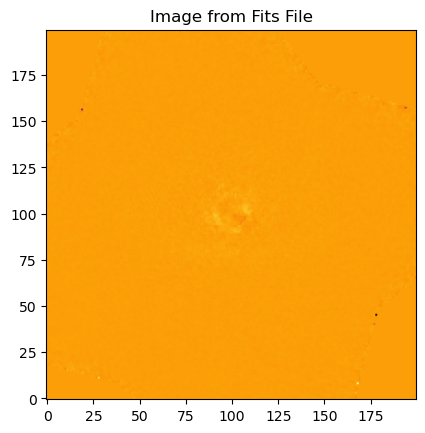

In [4]:
from optimization.optimize_framework import OptimizeUtils

fits_image_filepath = "test_images/" + row['Name'] + ".fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:], bounds=(40, 240, 40, 240))

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [5]:
from optimization.optimize_framework import Optimizer, OptimizeUtils
from disk_model.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from disk_model.SLD_ojax import ScatteredLightDisk
from disk_model.SLD_utils import *

### Initializing Relevant Parameters

In [6]:

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:], bounds=(40, 240, 40, 240))
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]), bounds=(40, 240, 40, 240)) #, outlier_pixels=[(57, 68)]))

In [10]:
scale_factor = 1
image = fits.open("PSFs/GPI_Hband_PSF.fits")[0].data[0,:,:]
scaled_image = (image[::scale_factor, ::scale_factor])[1::, 1::]
cropped_image = image[70:211, 70:211]
def safe_float32_conversion(value):
    try:
        return np.float32(value)
    except (ValueError, TypeError):
        print("This value is unjaxable: " + str(value))
emp_psf_image = np.nan_to_num(cropped_image)
emp_psf_image = np.vectorize(safe_float32_conversion)(emp_psf_image)

In [ ]:
start_disk_params = Parameter_Index.disk_params.copy()
start_spf_params = InterpolatedUnivariateSpline_SPF.params.copy()
start_psf_params = EMP_PSF.params.copy()
start_stellar_psf_params = LinearStellarPSF.params.copy()
start_misc_params = Parameter_Index.misc_params.copy()

start_disk_params = Parameter_Index.disk_params.copy()
start_disk_params['sma'] = row["Radius"]
start_disk_params['inclination'] = row["Inclination"]
start_disk_params['position_angle'] = row["Position Angle"]

start_spf_params['num_knots'] = 7 # int(row["Knots"])

start_misc_params['distance'] = row["Distance"]
start_misc_params['nx'] = 200
start_misc_params['ny'] = 200

start_disk_params['x_center'] = start_misc_params['nx']/2
start_disk_params['y_center'] = start_misc_params['ny']/2

opt = Optimizer(ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF,
                start_disk_params, start_spf_params, start_psf_params, start_misc_params)

opt.inc_bound_knots() # call this method only if you have a good predifined inclination, otherwise don't use it
opt.set_empirical_psf(emp_psf_image) # <-- Only necessary if you have an empirical_psf_image
opt.initialize_knots(target_image) # <-- This needs to be called first before any modeling or jit compiling if spline spf is being used

### JIT Compiling and Disk Modeling

In [13]:
opt.jit_compile_model() # <-- opt.log_likelihood is also jit compiled by this
opt.jit_compile_gradient(target_image, err_map) # <-- Not needed if gradient isn't going to be used

In [14]:
print(opt.log_likelihood(target_image, err_map))
opt.get_gradient(['sma', 'alpha_in', 'knot_values'], target_image, err_map)

-76701.03859948227


[Array(-4.20156392, dtype=float64),
 Array(-22.00378763, dtype=float64),
 Array([25.05495406, 43.8684832 , 15.16727068, 33.06186829, 18.48496472,
        25.22742856, 11.57232422], dtype=float64)]

Text(0.5, 1.0, 'Initial Guess, Log-Likelihood: -76701.03859948227')

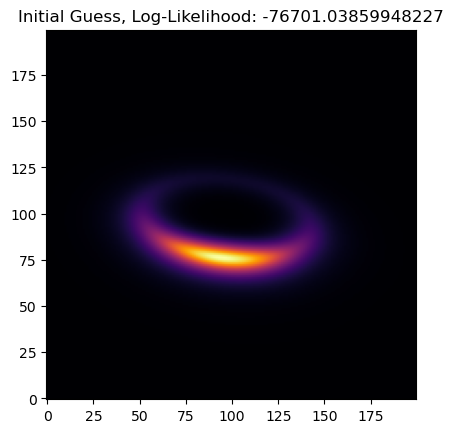

In [15]:
plt.imshow(opt.get_model(), origin='lower', cmap='inferno')
plt.title("Initial Guess, Log-Likelihood: " + str(opt.log_likelihood(target_image, err_map)))

In [16]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 5, 'alpha_out': -5, 'sma': 72.4, 'e': 0.0, 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 62.1, 'position_angle': 263.2, 'x_center': 100.0, 'y_center': 100.0, 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'backscatt_bound': Array(-0.88376563, dtype=float64, weak_type=True), 'forwardscatt_bound': Array(0.88376563, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([6.30559932, 2.60158116, 1.49650907, 1.        , 0.72802418,
       0.56031171, 0.44837867], dtype=float64)}
PSF Params: {'scale_factor': 1.0, 'offset': 1.0}
Stellar PSF Params: None
Misc Params: {'distance': 109.43, 'pxInArcsec': 0.01414, 'nx': 200, 'ny': 200, 'halfNbSlices': 25, 'flux_scaling': Array(89.88498635, dtype=float64)}


In [17]:
# Can enable these to debug jax issues
# jax.config.update('jax_debug_nans', True)
# jax.config.update('jax_debug_infs', True)

### Running Optimization

In [18]:

# Logscaling helps for fitting across orders of magnitude

fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'e']
logscaled_params = ['knot_values']
array_params = ['knot_values']
bounds = ([0.1, -15, 0, 0, 0, 90, 90, np.zeros(7), 0],
          [20, -0.1, 150, 180, 400, 110, 110, 1e4*np.ones(7), 1])

opt.scipy_bounded_optimize(fit_keys, bounds, logscaled_params, array_params, target_image, err_map, use_grad = True, disp_soln = True, iters = 2000)
optimal_image = opt.get_model()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 76132.40465934091
        x: [ 2.556e+00 -4.639e+00 ...  1.826e+00  0.000e+00]
      nit: 95
      jac: [-3.030e-02  1.119e-02 ... -5.148e-02  5.618e+01]
     nfev: 114
     njev: 114
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>


### Results

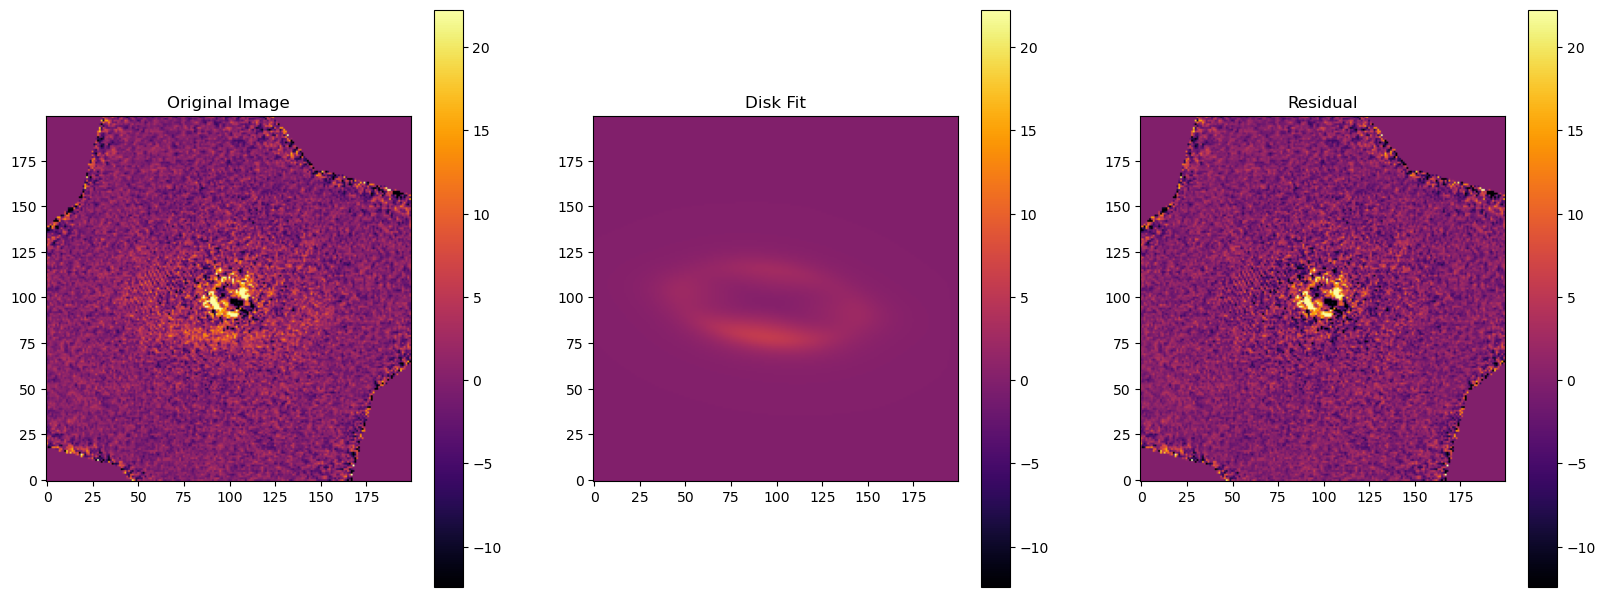

In [19]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 10)
vmax = np.nanpercentile(target_image[mask], 90)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

In [20]:
opt.scale_spline_to_fixed_point(0, 1)
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': np.float64(2.5563069976095867), 'alpha_out': np.float64(-4.638989118213119), 'sma': np.float64(81.89185304704225), 'e': np.float64(0.0), 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': np.float64(67.06553439207838), 'position_angle': np.float64(262.6278741351221), 'x_center': np.float64(98.58763160996777), 'y_center': np.float64(99.79549693947759), 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'backscatt_bound': Array(-0.88376563, dtype=float64, weak_type=True), 'forwardscatt_bound': Array(0.88376563, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([2.3615571 , 1.08089266, 0.88000461, 1.        , 0.86118949,
       0.68967264, 1.1086883 ], dtype=float64)}
PSF Params: {'scale_factor': 1.0, 'offset': 1.0}
Stellar PSF Params: None
Misc Params: {'distance': 109.43, 'pxInArcsec': 0.01414, 'nx': 200, 'ny': 200, 'halfNbSlices': 25, 'flux_scaling': Array(503.36501521, dtype=float64)}


## Running MCMC

In [21]:
# For MCMC, spline values are log scaled, the optimizer class passes them in as log(spf_params) and they are exponated in the lambda expression, this evens out the markov chains
# helping MCMC work better

fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'e']
logscaled_params = ['knot_values']
array_params = ['knot_values']
bounds = ([0.1, -15, 0, 0, 0, 90, 90, np.zeros(7), 0],
          [200, -0.1, 150, 180, 400, 110, 110, 1e4*np.ones(7), 1])

mc_model = opt.mcmc(fit_keys, logscaled_params, array_params, target_image, err_map, bounds, nwalkers=100, niter=100, burns=20)

Running burn-in...


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Running production...


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


In [22]:
mc_soln = mc_model.get_theta_median(scaled = True)
img = opt.get_model()

Text(0.5, 1.0, 'Post MCMC')

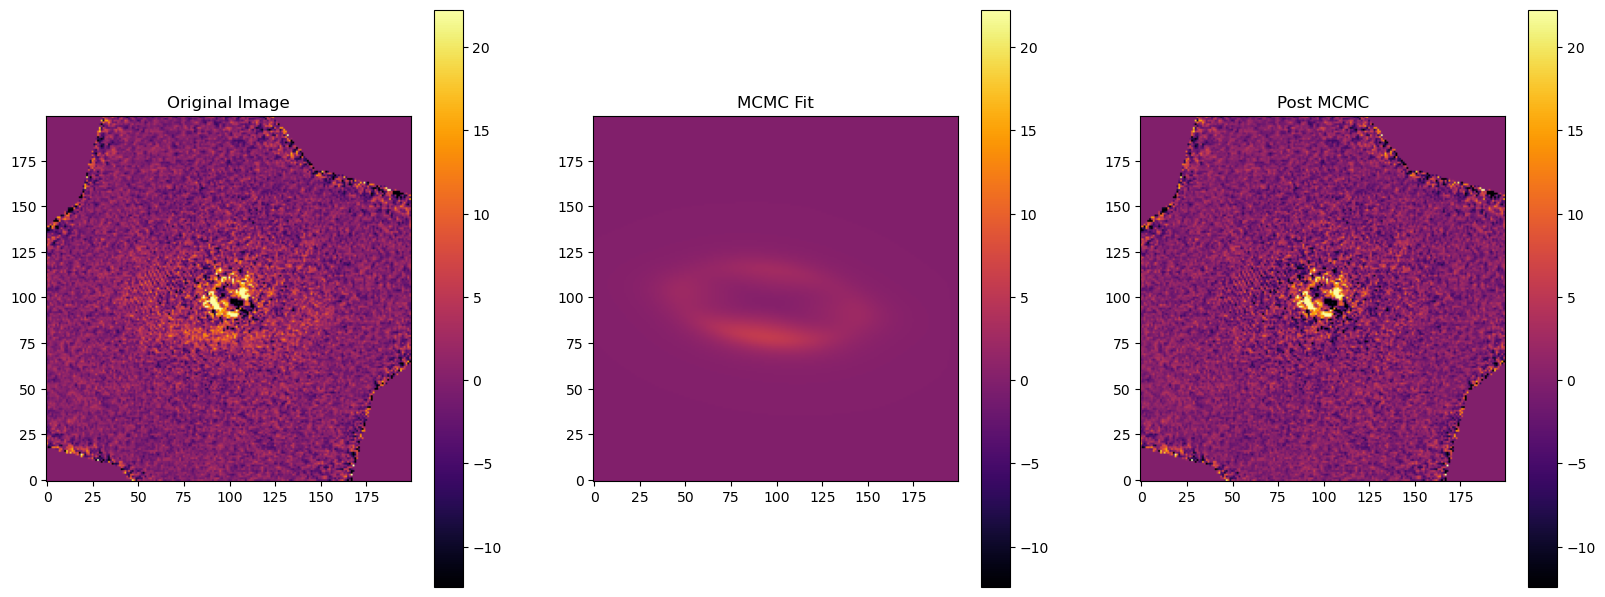

In [23]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 10)
vmax = np.nanpercentile(target_image[mask], 90)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno')
axes[1].set_title("MCMC Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)
plt.title("Post MCMC")

### Plotting MCMC Results

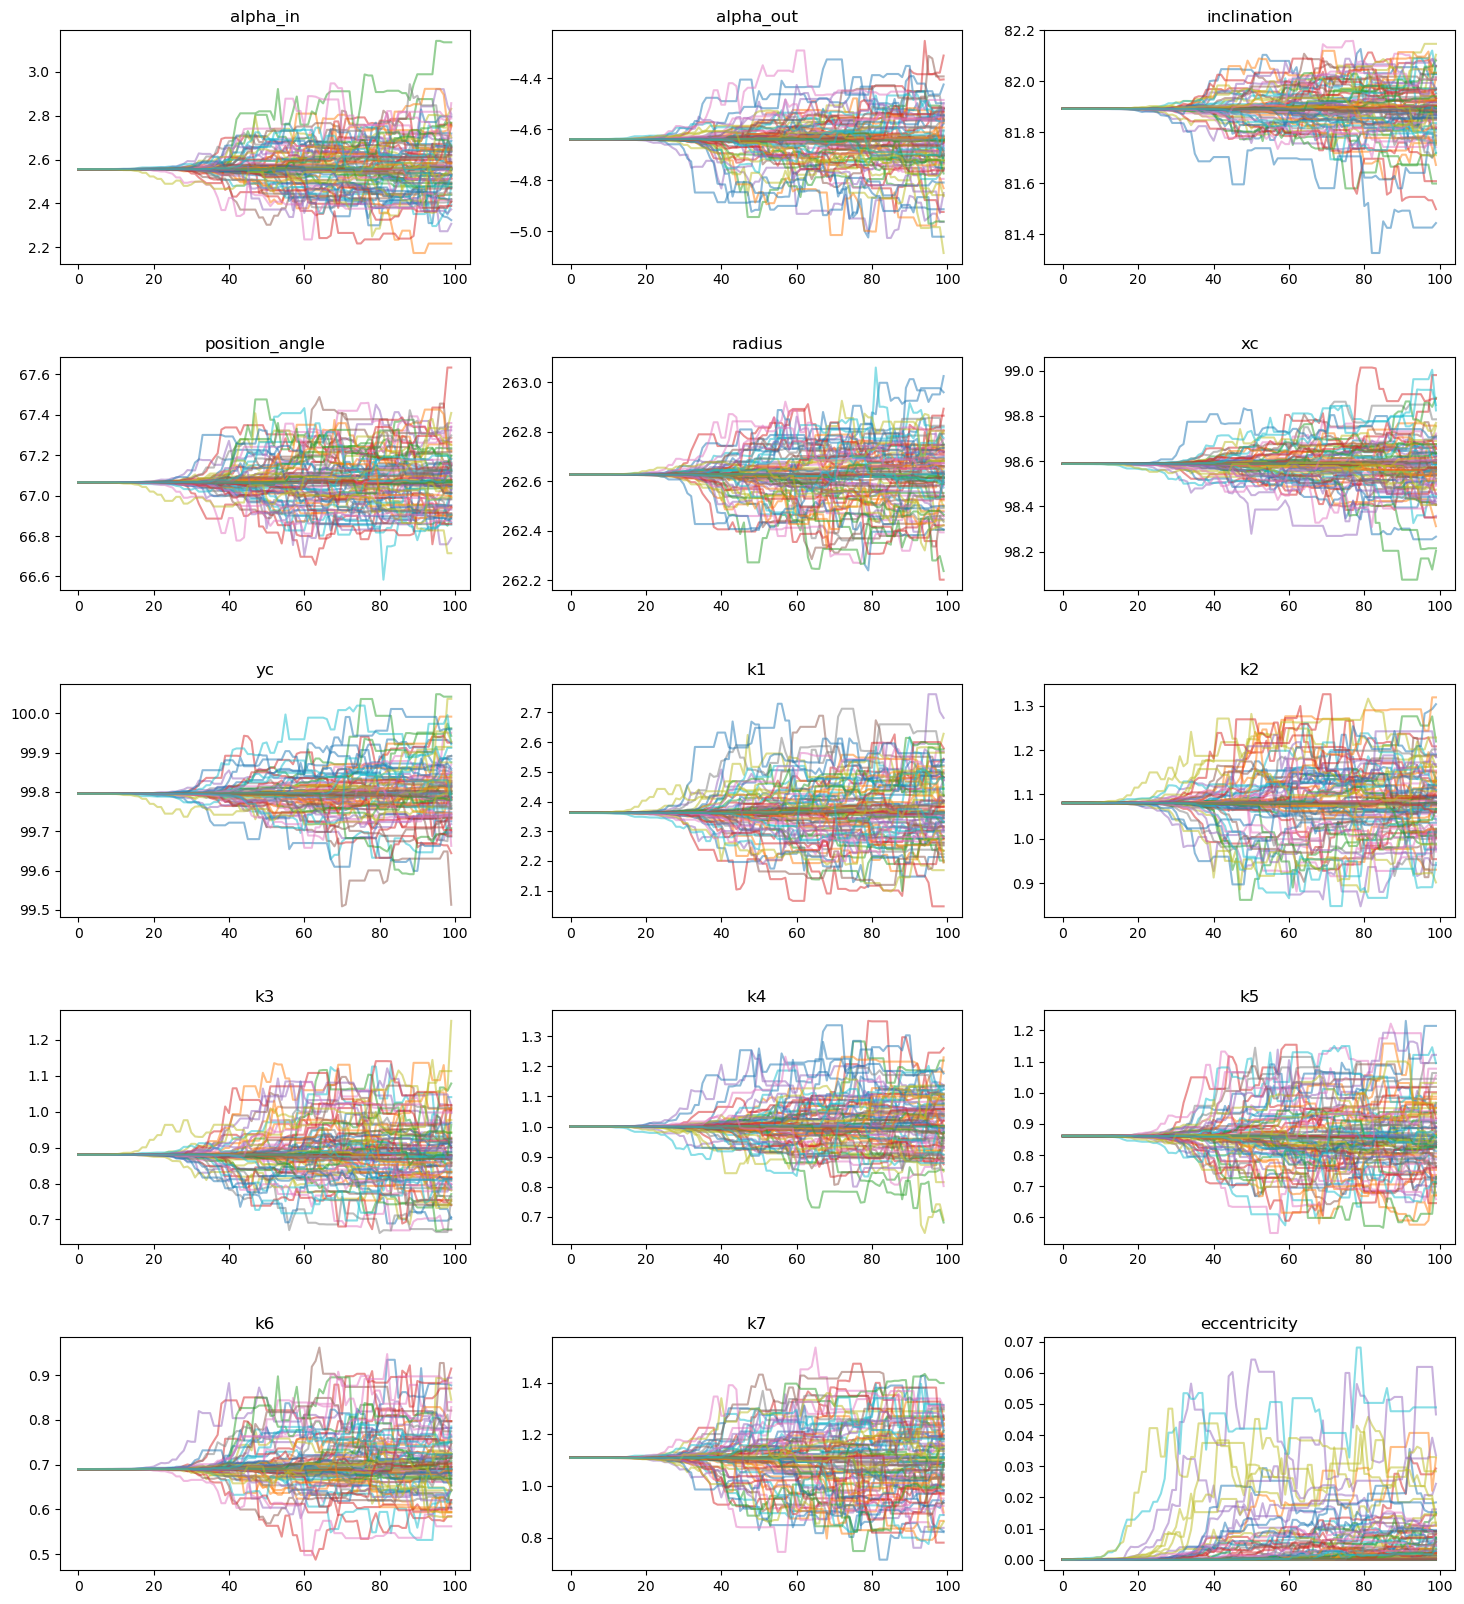

In [24]:
labels = ['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))
labels.append('eccentricity')
mc_model.plot_chains(labels, scaled = True)

### Corner Plot

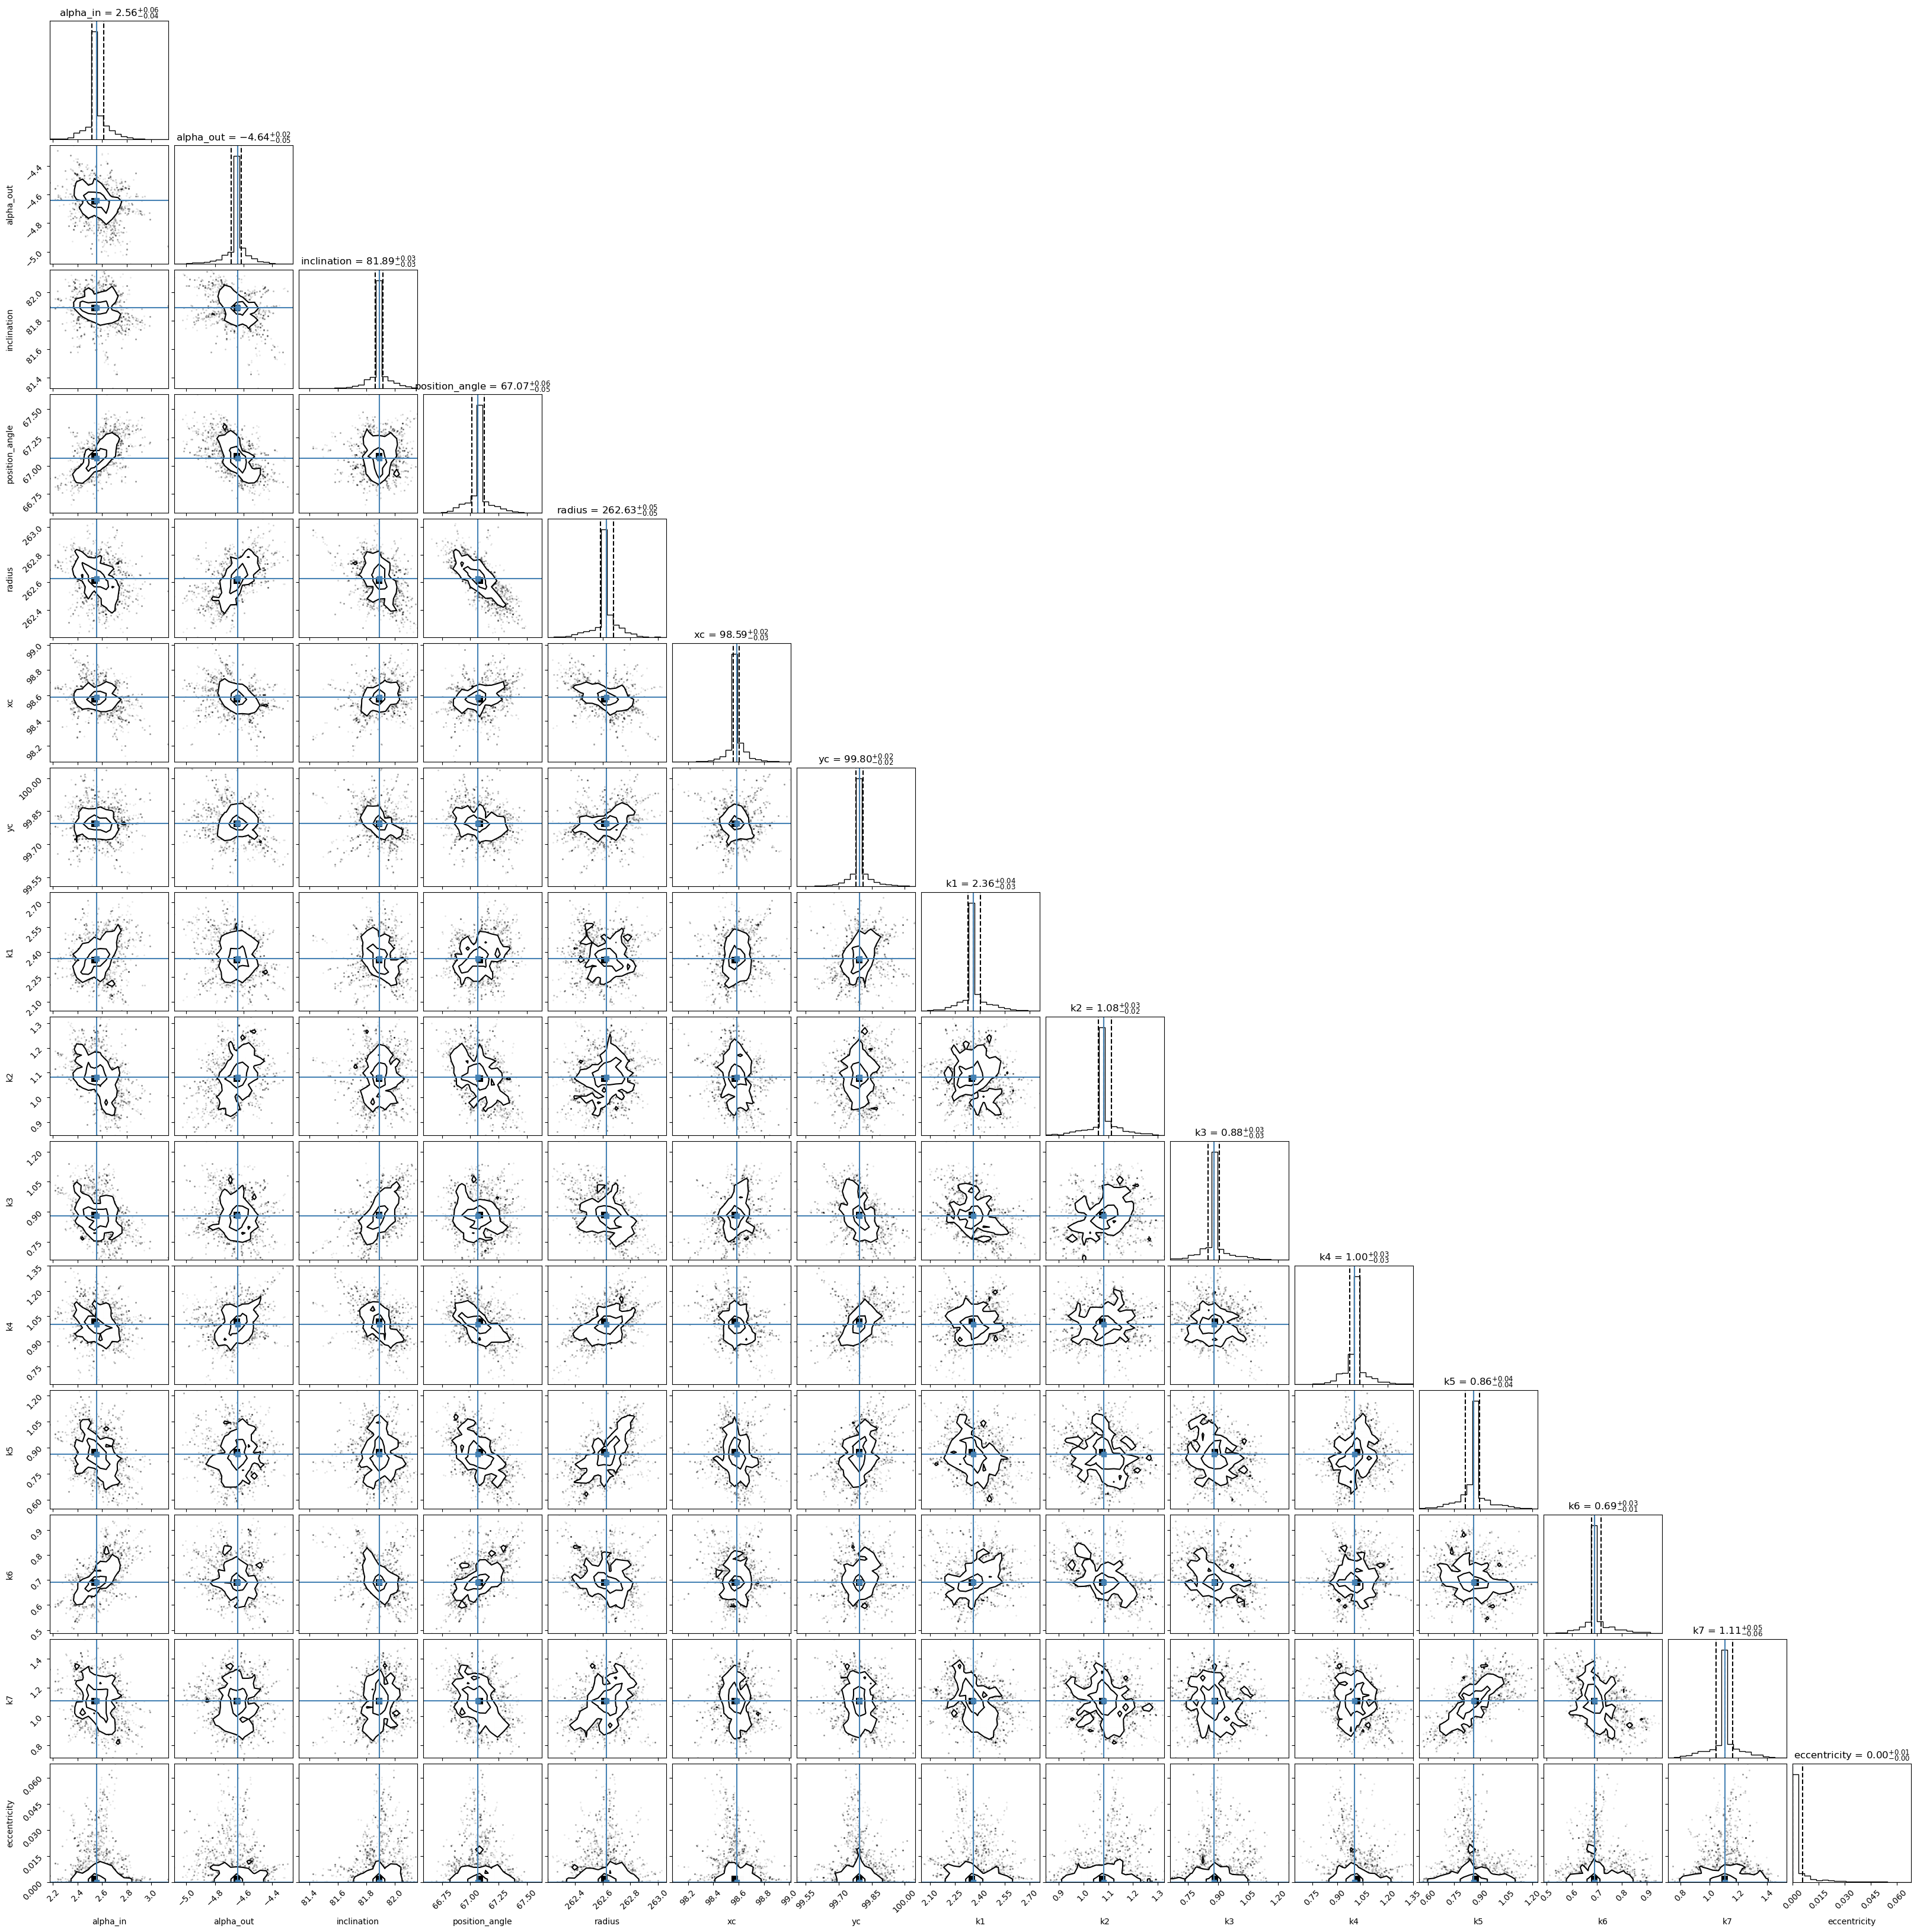

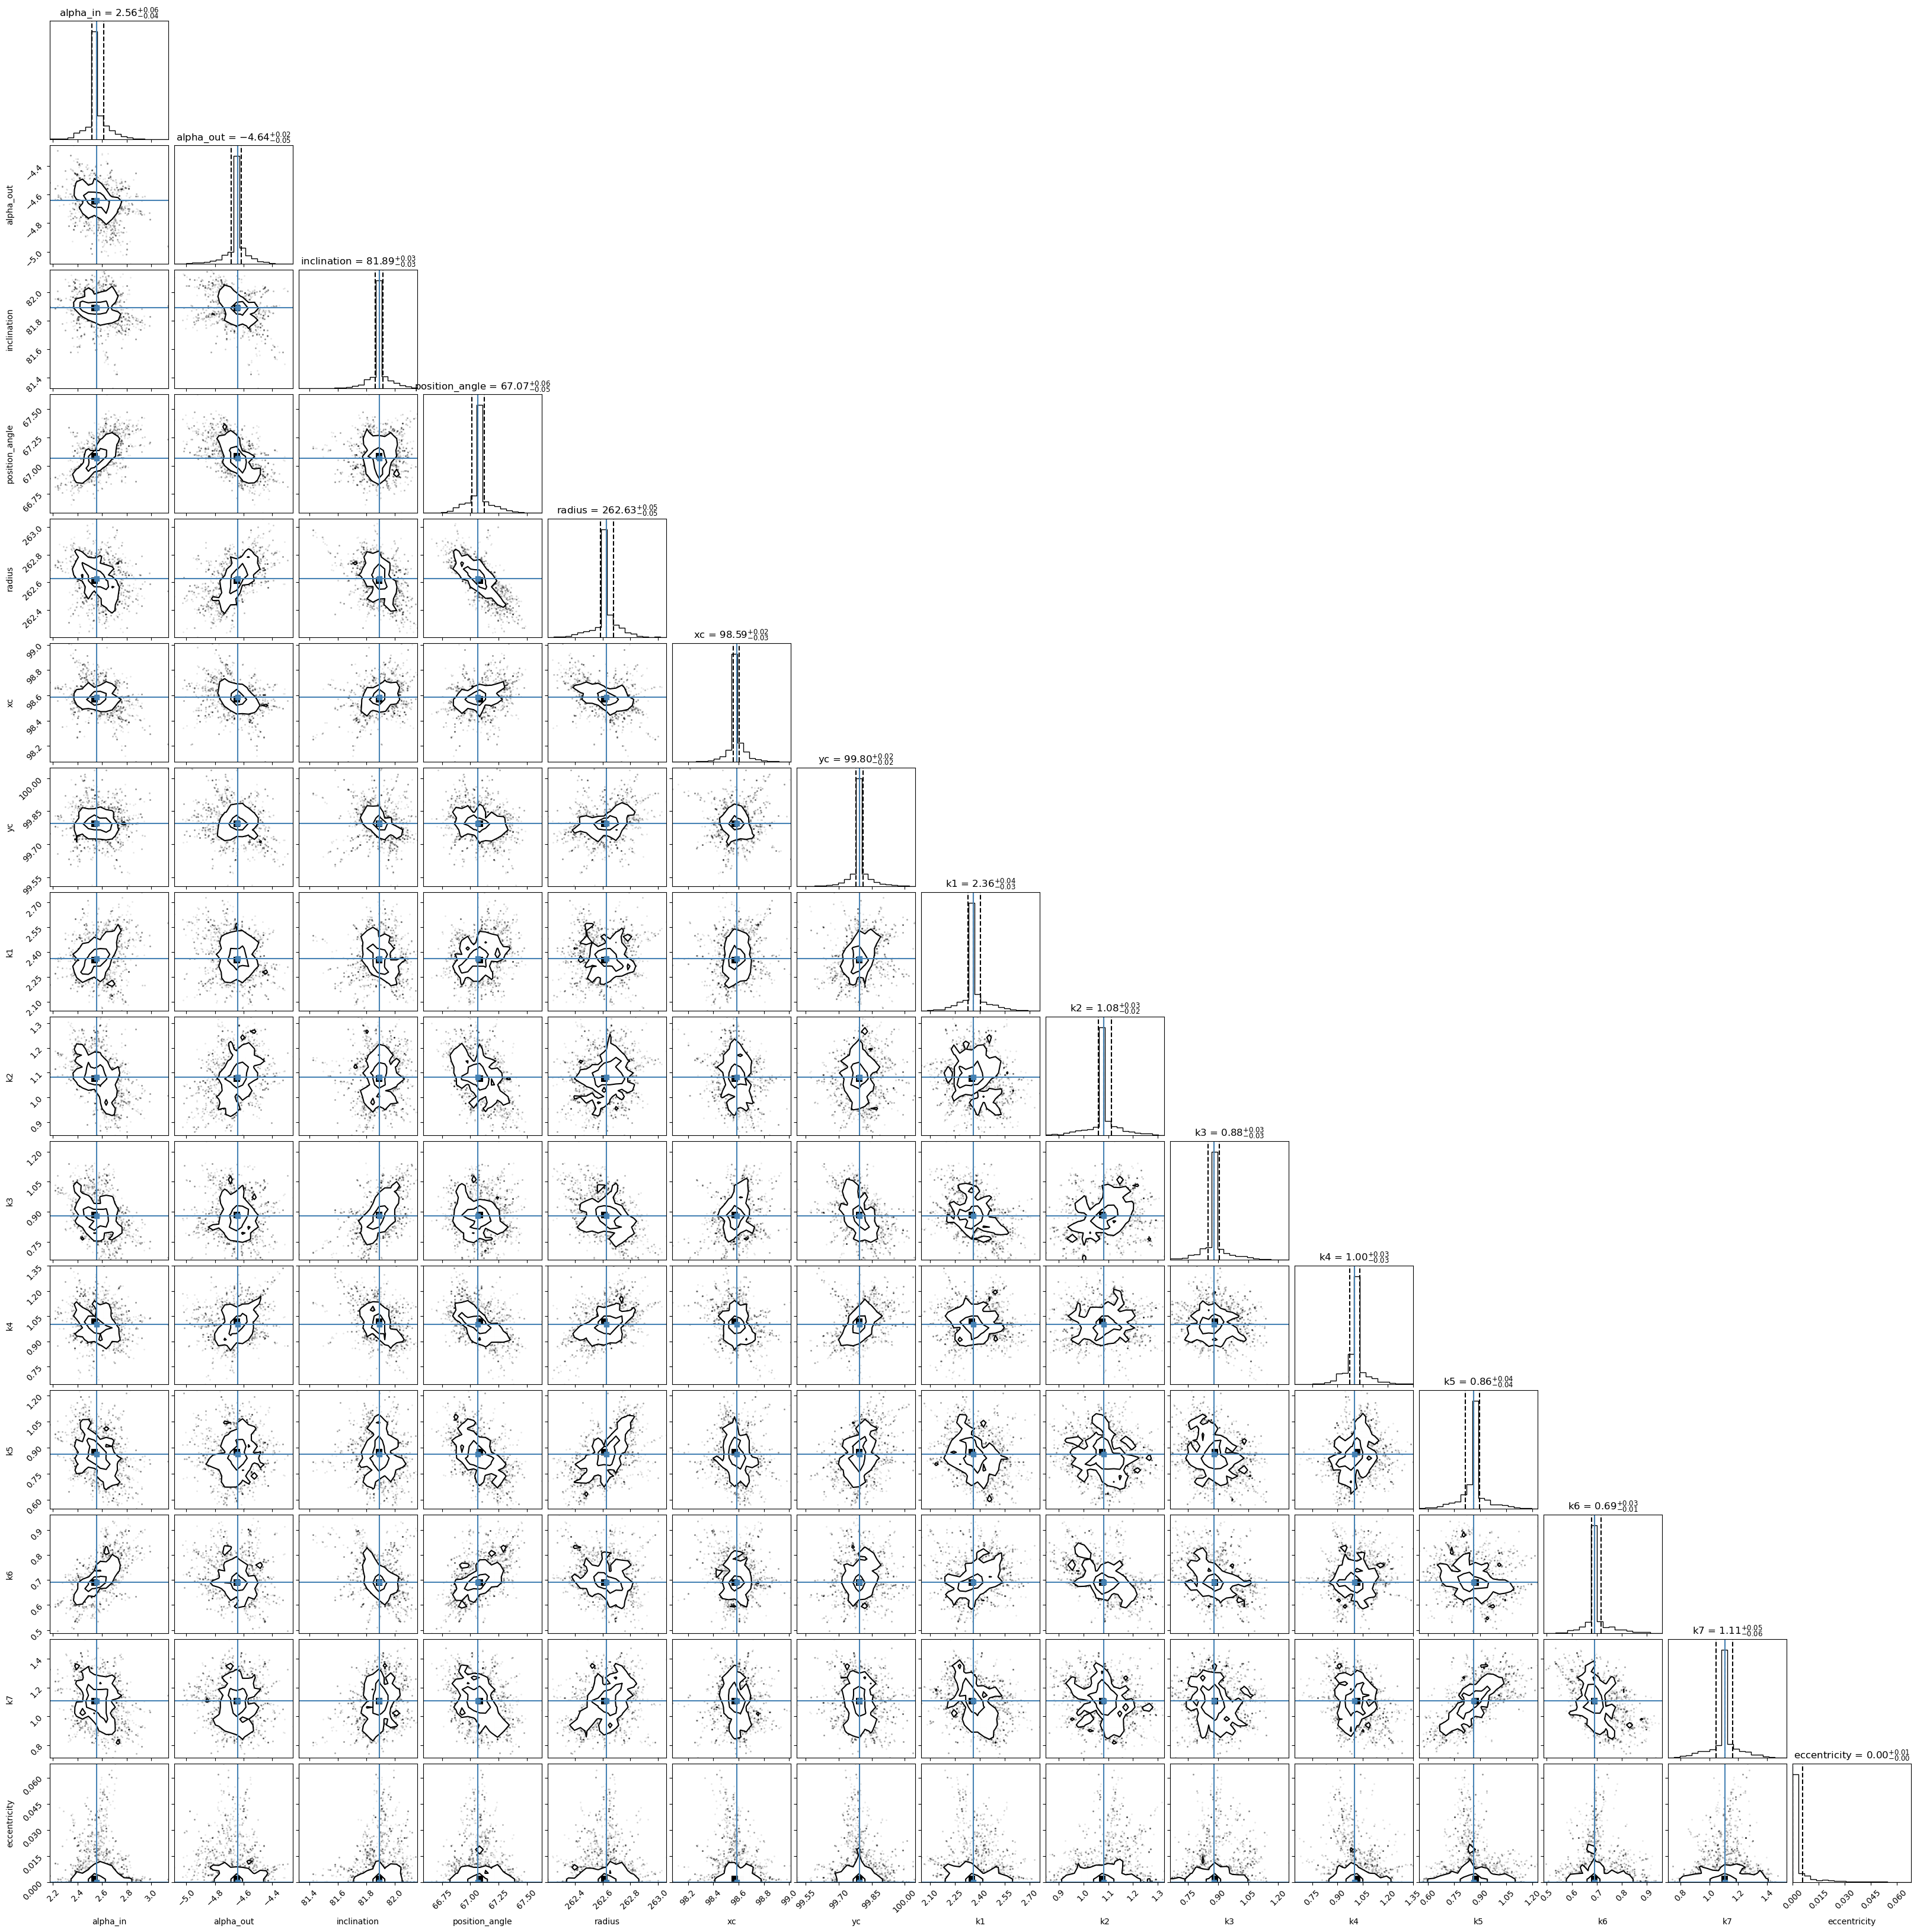

In [25]:
mc_model.show_corner_plot(labels, truths=mc_soln, scaled = True, quiet = True)

In [26]:
print(dict(zip(labels, mc_model.get_theta_median(scaled = True))))

{'alpha_in': np.float64(2.556308378013564), 'alpha_out': np.float64(-4.638991153313062), 'inclination': np.float64(81.89185288736317), 'position_angle': np.float64(67.0655359679188), 'radius': np.float64(262.62787454258114), 'xc': np.float64(98.5876310414605), 'yc': np.float64(99.79549570069642), 'k1': np.float64(2.361557528382896), 'k2': np.float64(1.080892830044141), 'k3': np.float64(0.8800038528805267), 'k4': np.float64(0.9999998988308441), 'k5': np.float64(0.8611862200323152), 'k6': np.float64(0.6896744279908741), 'k7': np.float64(1.1086867373298421), 'eccentricity': np.float64(4.953359340063864e-05)}
